In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from models.lightGBM import optuna_lightBGMs
from models.lightGBM import calculate_scores, plotImp
%matplotlib inline


drop_list=["id", "year", "Country", 'ws_min', 'ws_max', "ws_var", "ws_cnt"]
           #"temperature_cnt", "humidity_cnt",
           #"ws_cnt", "dew_cnt", 'co_cnt', 'o3_cnt', 'so2_cnt', 'no2_cnt', "dew_cnt"]
           #'pressure_min', 'pressure_max', "pressure_cnt", "pressure_var", "humidity_var",
           #"pressure_mid", "dew_var", 
           #'so2_min', 'so2_max'
           #'ws_min', 'ws_max', 'dew_min', 'dew_max', "humidity_min", 'humidity_max', 
    #'temperature_min', 'temperature_max', 'o3_min', 'o3_max', 'no2_min', 'no2_max'


    
    
def pd_city_concat(df):
    df["Country"] = df.groupby('Country').transform('count')["City"]
    df["City"] = df.groupby('City').transform('count')["Country"]
    return df

def equinox(df):
    #df.loc[df['year'] ==2019, 'year'] = 1
    #df.loc[df['year'] ==2020, 'year'] = 2
    #df.loc[df['year'] ==2021, 'year'] = 3
    df["cno2_25"] = (df["co_mid"]-df["co_min"])+(df["no2_mid"]-df["no2_min"])/df["ws_mid"]
    df["cno2_75"] = (df["co_max"]-df["co_mid"])+(df["no2_max"]-df["no2_mid"])/df["ws_mid"]
    df["no2o3_25"] = (df["o3_mid"]-df["o3_min"])+(df["no2_mid"]-df["no2_min"])/df["ws_mid"]
    df["no2o3_75"] = (df["o3_max"]-df["o3_mid"])+(df["no2_max"]-df["no2_mid"])/df["ws_mid"]
    df["cno2_ws_25"] = (df["co_mid"]-df["co_min"])+(df["no2_mid"]-df["no2_min"])/df["ws_mid"]
    df["cno2_ws_75"] = (df["co_max"]-df["co_mid"])+(df["no2_max"]-df["no2_mid"])/df["ws_mid"]
    df["o3so2_25"] = (df["o3_mid"]-df["o3_min"])+(df["no2_mid"]-df["no2_min"])/df["ws_mid"]
    df["o3so2_75"] = (df["o3_max"]-df["o3_mid"])+(df["no2_max"]-df["no2_mid"])/df["ws_mid"]
    return df

def df_preprocess(df):
    df = pd_city_concat(df)
    df = equinox(df)

    df = df.drop(drop_list, axis=1)
    #df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.fillna(0)
    #df.sort_values(by ='City', ascending = True, inplace = True) 
    return df

target_name = 'pm25_mid'
df = pd.read_csv('/Users/hagi/downloads/place/train.csv')
df = df_preprocess(df)
df.head()

,month,day,City,lat,lon,co_cnt,co_min,co_mid,co_max,co_var,...,dew_var,pm25_mid,cno2_25,cno2_75,no2o3_25,no2o3_75,cno2_ws_25,cno2_ws_75,o3so2_25,o3so2_75
0,1,1,1009,-27.46794,153.02809,38,0.749,2.590,2.633,0.850,...,13.424,19.901,2.327213,1.567816,2.384213,3.145816,2.327213,1.567816,2.384213,3.145816
1,1,1,1057,-12.46113,130.84185,47,2.594,3.181,4.828,1.208,...,2.021,13.741,0.645163,3.118350,4.538163,6.231350,0.645163,3.118350,4.538163,6.231350
2,1,1,1038,-37.81400,144.96332,17,1.190,1.197,2.200,0.248,...,6.355,25.918,0.851328,5.501813,12.635328,15.403813,0.851328,5.501813,12.635328,15.403813
3,1,1,717,-32.92953,151.78010,63,4.586,11.044,14.802,24.186,...,9.417,174.370,11.452036,17.177483,17.218036,37.652483,11.452036,17.177483,17.218036,37.652483
4,1,1,964,-31.95224,115.86140,47,4.689,8.681,11.100,10.011,...,4.109,167.063,12.242331,17.576616,10.250331,51.408616,12.242331,17.576616,10.250331,51.408616


In [2]:
#N = int(len(df)*0.08)
X = df.drop([target_name], axis=1)
y = df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(176346, 54) (19595, 54) (176346,) (19595,)


In [ ]:
params = {'objective': 'mean_squared_error', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 
          'feature_pre_filter': False, 'lambda_l1': 2.6303932412917227e-05, 'lambda_l2': 8.246302473073197, 
          'num_leaves': 202, 'feature_fraction': 0.6, 'bagging_fraction': 1.0, 'bagging_freq': 0, 
          'min_data_in_leaf': 20, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 50}

op_bgm = optuna_lightBGMs(params, X_train, X_test, y_train, y_test)
update_model, best_params = op_bgm.train()
print(best_params)
# {'objective': 'mean_squared_error', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 
#'feature_pre_filter': False, 'lambda_l1': 2.6303932412917227e-05, 'lambda_l2': 8.246302473073197, 
#'num_leaves': 171, 'feature_fraction': 0.6, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_data_in_leaf': 20, 
#'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 50}

In [4]:
y_pred = update_model.predict(X_test, num_iteration=update_model.best_iteration)
scores = calculate_scores(y_test, y_pred)
print(scores)

              R2        MAE         MSE       RMSE
scores  0.745702  13.864729  381.474847  19.531381


feature importance


,importance
co_mid,3276
co_min,3209
no2_mid,3126
no2_min,3117
lat,3039
o3_min,3038
so2_mid,3005
o3_mid,2997
so2_min,2874
temperature_mid,2832


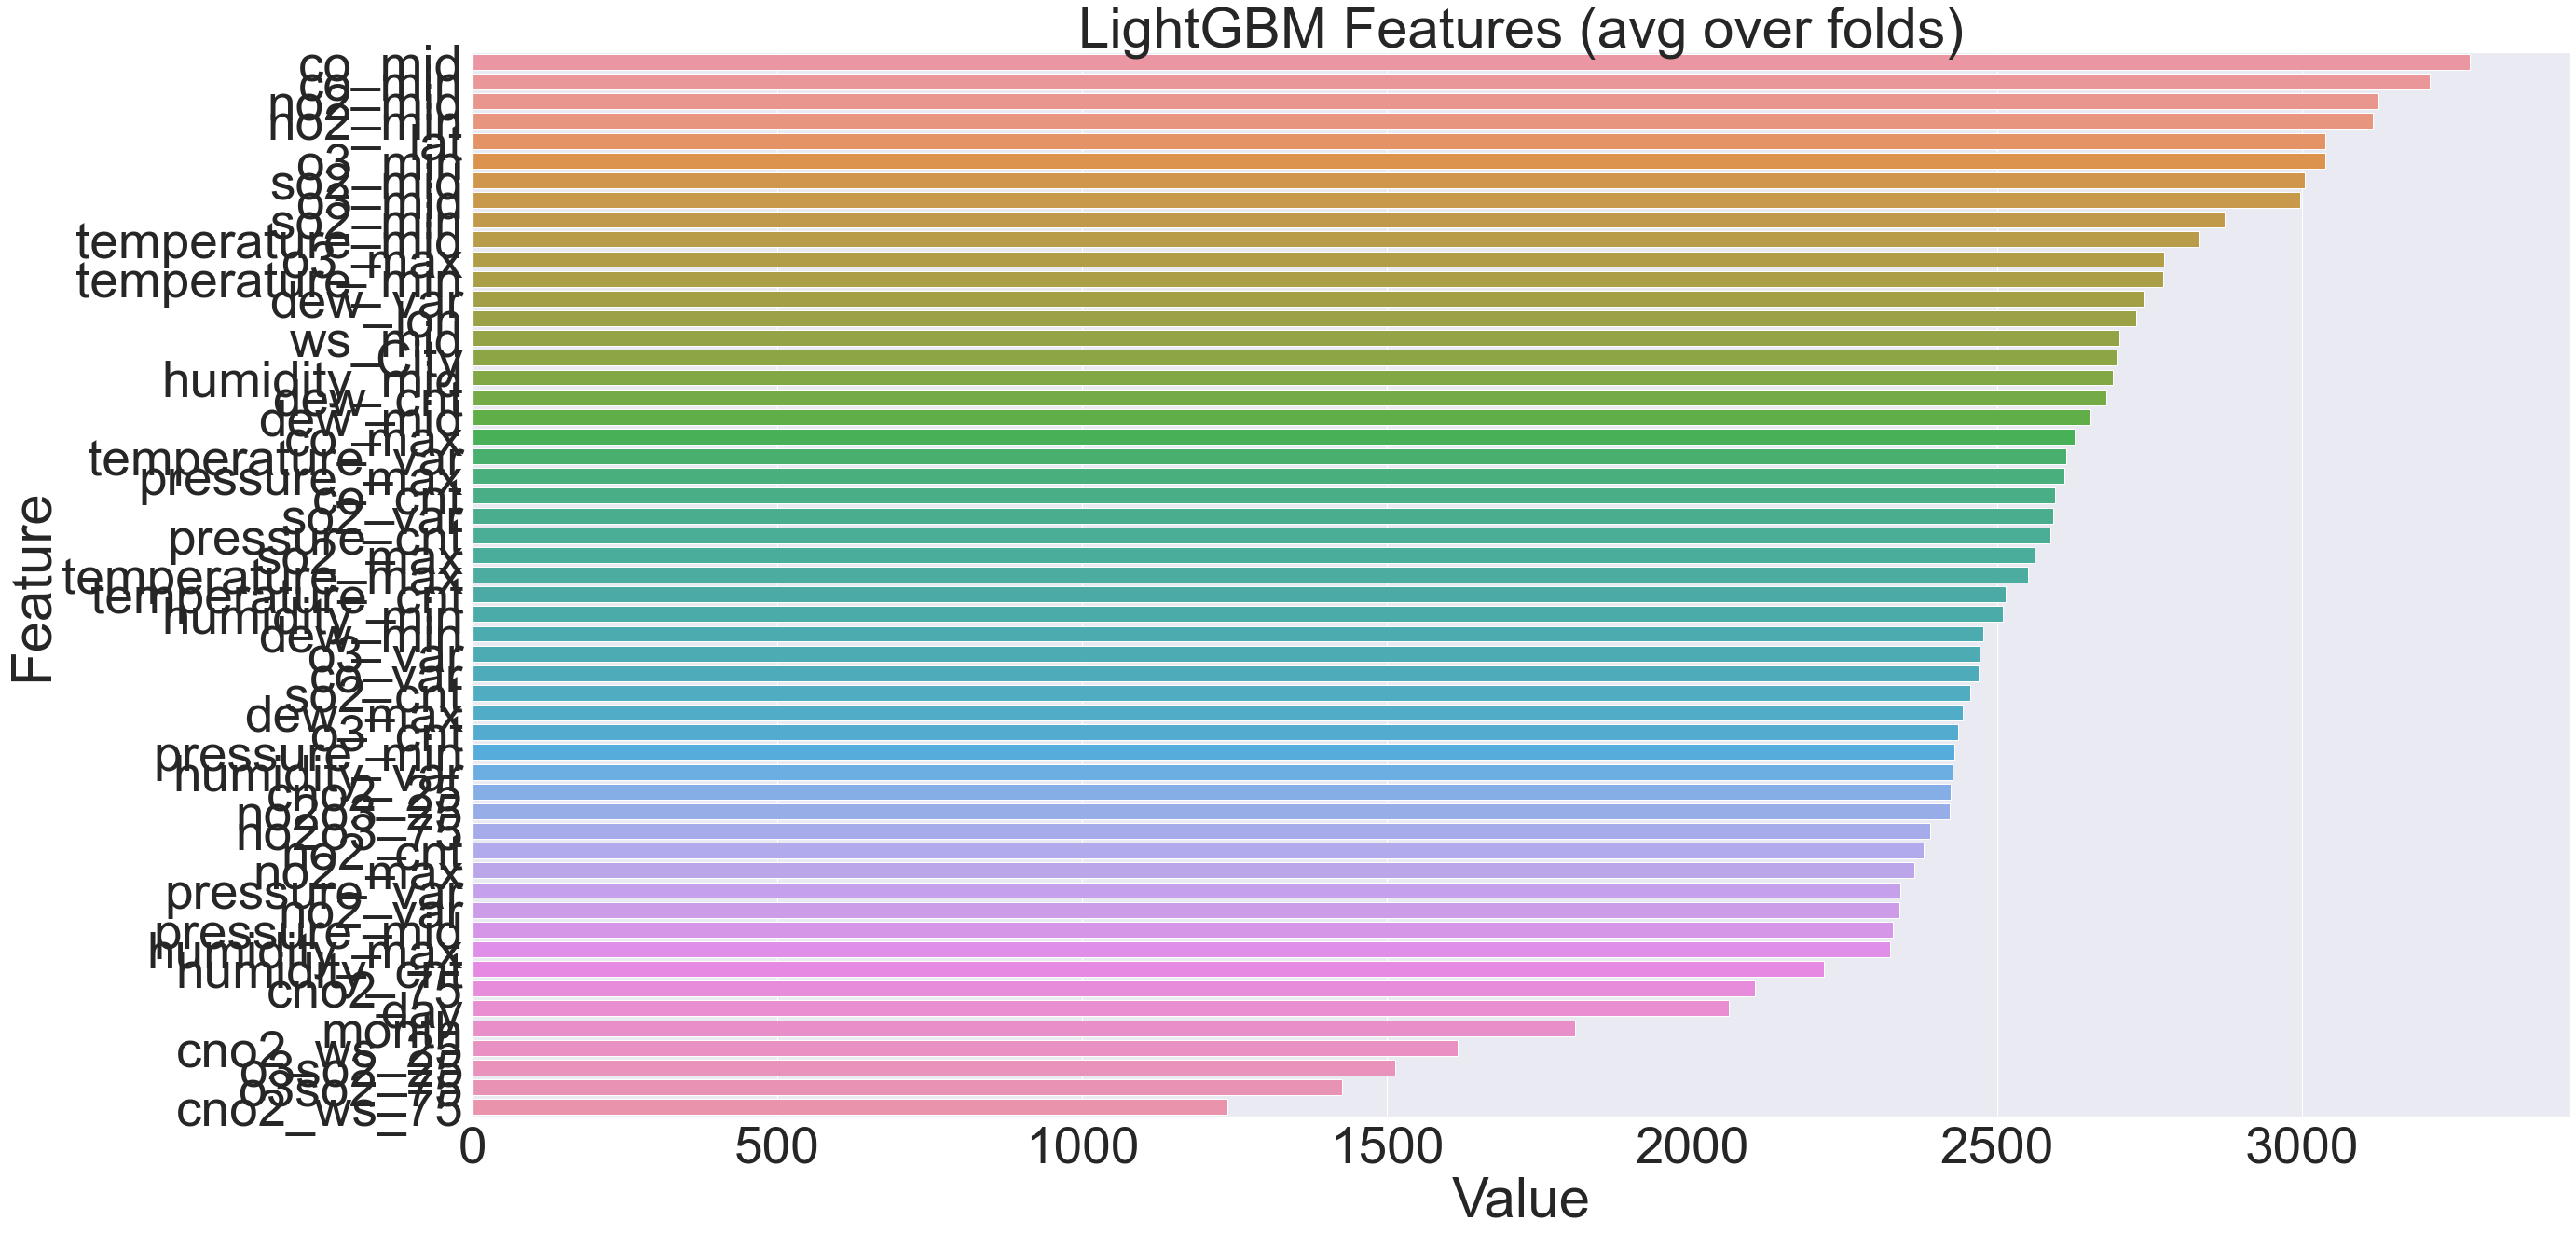

In [5]:
print("feature importance")
colum = df.drop([target_name], axis=1).columns
plotImp(update_model, colum, save_name='optuna_feature_imp.png', on_display=True)

In [6]:
X_test = pd.read_csv('/Users/hagi/downloads/place/test.csv')
X_test = df_preprocess(X_test)
y_pred = update_model.predict(X_test)
print(y_pred.shape)
dd = pd.DataFrame(y_pred)
dd.set_index(dd.index+195942).to_csv("submit_12.csv", header=False)

(53509,)
